In [1]:
import disentangler as dt
from disentangler.dependencies import *

rna_data, atac_data = dt.bonemarrow.utils.load_GEX_data(), dt.bonemarrow.utils.load_ATAC_data()

## Model without correction

In [3]:
rna_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_RNA_NO_CORRECTION)
atac_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_ATAC_NO_CORRECTION)

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [4]:
atac_model.predict(atac_data)
rna_model.predict(rna_data)

Predicting latent vars:   0%|          | 0/263 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


In [5]:
atac_model.get_umap_features(atac_data, box_cox=0.2)
rna_model.get_umap_features(rna_data, box_cox=0.2)

rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.utils:61127 out of 69076 cells shared between datasets (88%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features


In [6]:
rp_args = dict(
    expr_adata = rna_data,
    atac_adata = atac_data,
)

atac_data.var[['chr','start','end']] = \
    list(map(list, atac_data.var_names.str.split('-')))

mira.tl.get_distance_to_TSS(atac_data,
                            tss_data = 'data/bonemarrow/hg38_tss_data.bed12.filtered',
                            genome_file= 'data/bonemarrow/hg38.chrom.sizes'
                           )

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [7]:
litemodel = mira.rp.LITE_Model.load_dir(
    expr_model=rna_model,
    accessibility_model=atac_model,
    counts_layer='counts',
    prefix = 'data/bonemarrow/rp/litemodels_NOBATCH/'
)

In [8]:
litemodel.predict(**rp_args)

INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/239 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/239 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2813 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'spans', 'upstream-downstream'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:834: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


In [9]:
rna_data.layers['NOBATCH_LITE_logp'] = rna_data.layers['LITE_logp'].copy()
rna_data.layers['NOBATCH_LITE_prediction'] = rna_data.layers['LITE_prediction'].copy()
rna_data.varm['NOBATCH_LITE_model_logp'] = rna_data.varm['LITE_model_logp'].copy()

In [10]:
del rna_data.obs['model_read_scale'], rna_data.obs['softmax_denom'], atac_data.obs['softmax_denom']

In [11]:
del rna_data.obsm['X_topic_compositions'], atac_data.obsm['X_topic_compositions']

## Using disentangled models

In [2]:
rna_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_RNA + '2')
atac_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_ATAC)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site

rna_data, atac_data = dt.bonemarrow.utils.load_GEX_data(), anndata.read_h5ad('data/bonemarrow/rp/atac_data.h5ad')

In [3]:
atac_model.predict(atac_data)
rna_model.predict(rna_data)

Predicting latent vars:   0%|          | 0/263 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


In [4]:
atac_model.get_umap_features(atac_data, box_cox=0.2)
rna_model.get_umap_features(rna_data, box_cox=0.2)

rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)

rp_args = dict(
    expr_adata = rna_data,
    atac_adata = atac_data,
)

atac_data.var[['chr','start','end']] = \
    list(map(list, atac_data.var_names.str.split('-')))

mira.tl.get_distance_to_TSS(atac_data,
                            tss_data = 'data/bonemarrow/hg38_tss_data.bed12.filtered',
                            genome_file= 'data/bonemarrow/hg38.chrom.sizes'
                           )

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.utils:61127 out of 69076 cells shared between datasets (88%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features
INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [5]:
corrected_litemodel = mira.rp.LITE_Model.load_dir(
    expr_model=rna_model,
    accessibility_model=atac_model,
    counts_layer='counts',
    prefix = 'data/bonemarrow/rp/litemodels_adjusted//'
)

In [ ]:
corrected_litemodel.predict(**rp_args)

In [16]:
rna_data.write_h5ad('data/bonemarrow/rp/rna_rp_modeled_data.h5ad')

## Make graphics

In [50]:
rna_data = anndata.read_h5ad('data/bonemarrow/rp/rna_rp_modeled_data.h5ad')

In [69]:
rna_data.var['corrected_logp'] = (np.array(rna_data.layers['LITE_logp'].sum(0)).reshape(-1) + rna_data.varm['LITE_model_logp'])/rna_data.var.n_cells_by_counts
rna_data.var['not_corrected_logp'] = \
    (np.array(rna_data.layers['NOBATCH_LITE_logp'].sum(0)).reshape(-1) + rna_data.varm['NOBATCH_LITE_model_logp'])/rna_data.var.n_cells_by_counts
rna_data.var['delta_logp'] = np.exp(rna_data.var['corrected_logp'] - rna_data.var['not_corrected_logp'])

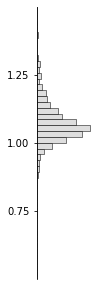

In [76]:
fig, ax = plt.subplots(1,1,figsize=(1,5))
sns.histplot(
    y = rna_data.var.loc[corrected_litemodel.features].delta_logp,
    ax = ax,
    color = 'lightgrey',
    bins=100,
    edgecolor = 'black',
    fill='black',
    linewidth = 0.5
)
ax.set(xticks = [], ylim = (0.5, 1.5), yticks = [0.75, 1, 1.25],
      xlabel = '', ylabel = '')
for t in ['top','bottom','right']:
    ax.spines[t].set_visible(False)
    
plt.savefig('figure1/RP_likelihood_ratio_nolog.svg')

In [6]:
rna_model.get_batch_effect(rna_data)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/239 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: batch_effect


In [7]:
from mira.plots import regulatory_dynamics_plot, rp_plots

tss_data = pd.DataFrame(mira.utils.fetch_TSS_data(atac_data)).T

def set_spines(ax, spines = ['left','bottom']):
    for spine in ['left','right','top','bottom']:
        if not spine in spines:
            ax.spines[spine].set_visible(False)

In [8]:
from lisa.core.genome_tools import Region
from matplotlib.patches import Rectangle, Polygon, FancyArrow

In [9]:
def plot_simple_gene_track(ax, color = 'lightgrey', linecolor = 'black', 
        linewidth = 1, alpha = 0.25, stack = True,*, 
        interval_chrom, interval_start, interval_end, 
        gene_id, chrom, start, end, strand):
    
    interval = Region(interval_chrom, interval_start, interval_end)
    
    arrow_properties = dict(
        width = 1., 
        color = 'black', 
        head_width = 1.,
        head_length = 5000,
        length_includes_head = True,
    )
    
    n_genes_plotted = 0
    for _gene, _chrom, _start, _end, _strand in zip(gene_id, chrom, start, end, strand):
        
        gene_bounds = Region(_chrom, _start, _end)
        if gene_bounds.overlaps(interval) and _gene in rna_data.var_names:
            if _strand == '+':
                ax.add_patch(FancyArrow(_start, n_genes_plotted, _end - _start, 0, **arrow_properties) )
            else:
                ax.add_patch(  FancyArrow(_end, n_genes_plotted, -(_end - _start), 0, **arrow_properties))
            ax.text(_end + 1000, n_genes_plotted, _gene, va = 'center')
            n_genes_plotted+=stack
            
    ax.add_patch(
        Rectangle((0,interval_end-100000), 100000,1)
    )
            
    ax.set(ylim = (-0.5, n_genes_plotted + 0.5))

In [10]:
signature = 'ACSL6	OSM	ATP1B2	PRSS57	SLFN14	PHOSPHO1	RHCE	XK	LGALS12	CR1L	UBXN10	TFR2	MYL4	TMCC2	TRIM10	YPEL4	OSBP2	EPB42	TUBB1	CPOX	FOXO4	EPX	AQP1	ITLN1	MYC	GRAP2	UBASH3A	HES6	DCLRE1A	KCNH2	HBG1	HBG2	PRG2	ANK1	GBGT1	KEL	FHDC1	KLRB1	C17ORF99	RFESD	ACSM1	PRF1	ESPN	GATA1	FAM65C	ERMAP	TESC	HBA1	HBA2	SPTB	PDZK1IP1	TSPO2	ADIPOR1,	RP11-872D17.8	MS4A3	KCNK5	ACHE	ST6GALNAC1	GYPB	GYPA	SMIM5	HBB	GYPE	SMIM1	HBD	BTNL10	RAP1GAP	SPTA1	EPCAM	CA2	CA1	HBM	OR2W3	CA3	HBQ1	CD36	RAB6B	CTSE	CR1	TMOD1	DMTN	ARG1	PKLR	SLC2A14	KLF1	BPGM	PTH2R	EPOR	SELENBP1	TSPAN17	APOC1	ACKR1	TMEM56	DNAJA4	IFIT1B	RHAG	ALAS2	NPL	SLC4A1	ITGAM	CST7	ADD2	FAM178B	MGAT3	DCAF12	ATP7B	AHSP	MFSD2B'.split('\t')

rna_data.var.loc[np.intersect1d(np.intersect1d(rna_model.get_top_genes(1, 200), signature), corrected_litemodel.features)]['delta_logp'].sort_values()\
    .tail(25)

/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/adata_interface/rp_model.py:315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proximal_peaks['distance_to_TSS'] = np.abs(dist)
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/adata_interface/rp_model.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proximal_peaks['is_upstream'] = dist <= 0


Predicting expression:   0%|          | 0/1 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'spans', 'upstream-downstream'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp
Intersecting RP models with interval: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 372.86it/s]


Plotting fragments:   0%|          | 0/13382 [00:00<?, ?it/s]

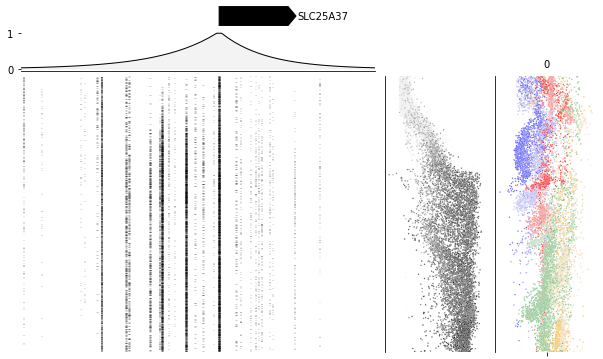

In [12]:
m = ~rna_data.obs.GEX_pseudotime_order.isna()
g = 'SLC25A37'

local_peaks = corrected_litemodel[g].get_influential_local_peaks(atac_data)

pos_strand = tss_data.loc[g].gene_strand == '+'
start_loc = tss_data.loc[g].gene_start if pos_strand else tss_data.loc[g].gene_end
params = corrected_litemodel[g].parameters_

distances = [params['distance_upstream'], params['distance_downstream']]
left, right = distances if pos_strand else distances[::-1]
track_args = dict(
    interval_chrom=local_peaks.iloc[0]['chr'],
    interval_start=int(start_loc - left*1000*5),
    interval_end= int(start_loc + right*1000*5),
    gene_id=tss_data.index.values,
    chrom=tss_data.gene_chrom.values,
    start = tss_data.gene_start.values,
    end = tss_data.gene_end.values,
    strand = tss_data.gene_strand.values
)

corrected_litemodel.subset([g]).predict(**rp_args)

#print(rna_data.var.loc[g]['delta_logp'])

## SETUP AXES ##
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(3, 3,  width_ratios=(7, 2, 2), height_ratios=(0.5,1,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

panel = fig.add_subplot(gs[2, 0])
rp_model = fig.add_subplot(gs[1, 0], sharex=panel)
genetrack = fig.add_subplot(gs[0,0], sharex = panel)
score = fig.add_subplot(gs[2, 1], sharey=panel)
batcheffect = fig.add_subplot(gs[2, 2], sharey=panel)

## RP PLOT ##
rp_plots._plot_rp_models(rp_model, 
                         rp_models=corrected_litemodel.subset([g]),
                            
                         **track_args)
set_spines(rp_model, ['bottom'])
rp_model.set(yticks = [0.,1.], xticks = [])

## GENE TRACK ##
plot_simple_gene_track(genetrack, stack = False,**track_args)
set_spines(genetrack, [])
genetrack.set(yticks = [])

## FRAGMENTS ##
if True:
    regulatory_dynamics_plot.plot_fragment_heatmap(panel,
        accessibility=atac_data[m].X, 
        chrom = track_args['interval_chrom'],
        start = track_args['interval_start'],
        end = track_args['interval_end'],
        peaks = atac_data[m].var[['chr','start','end']].values,
        time = atac_data[m].obs_vector('GEX_pseudotime_order'),
        height=0.1,
        alpha_mod=0.25,
    )
set_spines(panel, [])
#panel.set_xticks(list(range(4420000, 44656763, 10000)))

## RP Predictions ##
m = ~rna_data.obs.GEX_pseudotime_order.isna()
sns.scatterplot(
    ax = score,
    y = (rna_data[m].obs_vector('GEX_pseudotime_order')).argsort().argsort(),
    x = np.log(rna_data[m].obs_vector(g, layer='LITE_prediction')),
    hue = rna_data[m].obs_vector(g),
    palette=sns.color_palette('light:black', as_cmap=True),
    s = 2,
    legend=False
)
set_spines(score, ['left',])
score.set(xticks = [], yticks = [])


sns.scatterplot(
    ax = batcheffect,
    y = (rna_data[m].obs_vector('GEX_pseudotime_order')).argsort().argsort(),
    x = rna_data[m].obs_vector(g, layer='batch_effect'),
    hue = rna_data[m].obs_vector('batch'),
    palette=dt.bonemarrow.colors.BATCH_PALETTE.values(),
    hue_order=dt.bonemarrow.colors.BATCH_PALETTE.keys(),
    s = 2,
    legend=False
)
batcheffect.set(xticks = [0], yticks = [])
set_spines(batcheffect, ['left'])
batcheffect.xaxis.set_tick_params(labeltop=True)
batcheffect.xaxis.set_tick_params(labelbottom=False)

plt.savefig('figure1/SLC25A37_fragment_panel.png',
           bbox_inches = 'tight', dpi = 300)

In [175]:
# HBD